### Graph Neural Networks for Fashion Product Recommendations

github repo: https://github.com/ayeshavm/gnn-fashion-recommendation

#### 1. **Introduction**

Fashion discovery on platforms like Pinterest is driven by recommendations that help users find relevant products based on their preferences. In this project, we build a Graph Neural Network (GNN) that learns product relationships and generates meaningful recommendations.

- Goal: Develop a fashion recommendation system that suggests similar products based on learned embeddings.



#### 2. [**Data**](#data)

The dataset used in this project was obtained from Pinterest Fashion Data, which includes product metadata, images, and scene relationships.

Wang-Cheng Kang, Eric Kim, Jure Leskovec, Charles Rosenberg, Julian McAuley (2019). Complete the Look: Scene-based Complementary Product Recommendation. In Proceedings of IEEE Conference on Computer Vision and Pattern Recognition (CVPR'19)

Two main files were used:

- **fashion.json** – Contains product-to-scene relationships (which products appear together).
- **fashion-cat.json** – Contains product category information (multi-label classification).

##### 2.1 **Data Description**
| **Feature**               | **Description**                                                       |
|---------------------------|------------------------------------------------------------------------|
| **Product ID**            | Unique identifier for each fashion product                            |
| **Scene ID**              | Unique identifier for scenes containing multiple products             |
| **Bounding Box**          | (x, y, w, h) coordinates for product location in scene images         |
| **Category**              | Multi-label category for each product (e.g., "Shoes \| Sneakers")     |
| **Image URL**             | Direct URL to product images                                          |


##### 2.2 **Data Processing**
- **Removed the broad category** "Apparel & Accessories" to improve feature distinctiveness.
- **Extracted meaningful relationships** for graph construction.
- **Normalized product embeddings** before similarity computation.
- **One-hot encoded** product category labels.


### **3. Feature Engineering**
[We created meaningful **node features** and **edge connections** to represent product relationships effectively.](#graph)

#### **Node Features**
**Category Vector:** One-hot encoded product category labels.  


#### **Graph Edges (Relationships)**
| **Edge Type**                                         | **Description**                                              |
|------------------------------------------------------|--------------------------------------------------------------|
| **Product ↔ Scene**                                  | Links a product to the scenes it appears in.                |
| **Product ↔ Product (Category Similarity)**          | Connects products that share the same category.             |
| **Product ↔ Product (Object Similarity)**            | Links products with similar detected objects.               |
| **Scene ↔ Scene**                                    | Connects scenes with overlapping products.                  |


**Graph Statistics:**
- **Total Nodes:** `67,549` (Products + Scenes)  
- **Total Edges:** `72,198` (Relationships)  



### **4. Exploratory Data Analysis (EDA)**
- Visualized category distribution to ensure a diverse dataset.
- Plotted scene-product relationships to understand co-occurrences.
- Checked bounding box coverage to validate object localization.
- Ran PCA and t-SNE to analyze embeddings.

**Key Findings:**
- Most products belonged to a few dominant categories.
- Category-based edges were too dominant, leading to over-similar embeddings.  
- Scene-based connections improved embedding diversity.


### **5. Modeling & Hyper-parameter Tuning**
We trained a Graph Neural Network (GNN) using PyTorch Geometric (PyG).

#### **5.1 Model: Graph Attention Network (GAT)**
Graph Attention Networks (GAT) are a type of GNN that uses attention mechanisms to weigh the importance of neighboring nodes dynamically. Instead of treating all neighbors equally, GAT learns attention coefficients that allow the model to focus more on important relationships.

- Uses self-attention to compute the importance of connected nodes.
- Aggregates information from neighbor nodes using weighted importance.
- Helps improve learning in heterogeneous graphs, where some relationships are stronger than others.

#### **5.1.1 Model Architecture**
- 2-layer GAT with residual connections to prevent over-smoothing.  
- Dropout (0.3) to reduce overfitting.
- Contrastive Loss to encourage embedding separation.  

#### **5.1.2 Loss Function : Contrastive Loss**
Contrastive loss is used to push similar products closer together while **separating dissimilar products** in embedding space. This ensures that related items have more aligned feature representations while keeping unrelated items apart.


### **6. Evaluation**
Since this is an unsupervised learning model, traditional accuracy metrics don’t apply. We used:

- Loss Curve Analysis – Monitored contrastive loss over epochs.  
- Product Embedding Clusters (K-Means + PCA) – Checked if similar products clustered together.  
- Cosine Similarity Analysis – Measured how well products in the same category were grouped.  
- Recommendation Quality (Top 5 Nearest Neighbors) – Verified recommendations visually.

**Key Findings:**
- Similarity Scores Were Too High (~0.999), Suggesting Over-Smoothing.
- Clusters Overlapped, Indicating the Model Wasn't Fully Separating Products.  
- Scene-Based Relationships Improved Diversity.


### **7. Results & Summary**

- The model learned meaningful relationships between products.
- K-Means clustering identified distinct product groups.
- Scene-based edges improved diversity in recommendations.

**Limitations:**
- Embeddings were too similar (High Cosine Similarity ~0.999).
- Over-smoothing caused some loss of distinctiveness in product categories.

**Final Cosine Similarity Score:** `1.9299 (Too High, Needs Improvement)` !



## **8. Future Work**
- Try GraphSAGE Instead of GAT – To reduce over-smoothing.  
- Improve Contrastive Loss – Use Triplet Loss or InfoNCE Loss to push apart embeddings.  
- Refine Edge Selection** – Use **text embeddings (BERT/CLIP) to form better product relationships.  
- Train on a Larger & More Diverse Dataset – More varied product scenes could improve embeddings.  
- Implement YOLO-Based Object Detection – To capture object-level similarities in product images and enhance relationship mapping.  

Final Takeaway:
- If a user pins a product on Pinterest, our model can recommend visually and categorically similar items.
- Further improvements are needed to make embeddings more distinct and meaningful.


In [ ]:
import os
import zipfile
import pandas as pd
import shutil
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# !pip install torch_geometric
# !pip install ultralytics

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GraphSAGE, GATConv
import networkx as nx
import pandas as pd
import json
from sklearn.preprocessing import MultiLabelBinarizer
from transformers import AutoTokenizer, AutoModel
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import requests
from io import BytesIO
from ultralytics import YOLO
import os


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


<a id="data"></a>
###  Data Processing

In [ ]:
base_dir = 'drive/MyDrive/Colab Notebooks/UCB Deep Learning/week6'
file_path = os.path.join(base_dir, "kang205-data", "fashion.json")
fashion_data = []

with open(file_path, "r", encoding="utf-8") as f:
    for line in f:
        fashion_data.append(json.loads(line.strip()))

file_path_cat = os.path.join(base_dir, "kang205-data", "fashion-cat.json")
fashion_cat_data = []

with open(file_path_cat, "r", encoding="utf-8") as f:
    for line in f:
        fashion_cat_data.append(json.loads(line.strip()))  # Load each line as a JSON object

# Convert to DataFrame
fashion_data = pd.DataFrame(fashion_data)


In [ ]:
def convert_to_url(signature):
    prefix = 'http://i.pinimg.com/400x/%s/%s/%s/%s.jpg'
    return prefix % (signature[0:2], signature[2:4], signature[4:6], signature)


fashion_data['product_image_url'] = fashion_data['product'].apply(convert_to_url)
fashion_data['scene_image_url'] = fashion_data['scene'].apply(convert_to_url)

# Display updated data
print("Updated Data with Image URLs:")
print(fashion_data[['product', 'scene', 'product_image_url', 'scene_image_url']].head())

fashion_cat_dict = fashion_cat_data[0]

Updated Data with Image URLs:
                            product                             scene  \
0  0027e30879ce3d87f82f699f148bff7e  cdab9160072dd1800038227960ff6467   
1  0027e30879ce3d87f82f699f148bff7e  14f59334af4539132981b1324a731067   
2  0027e30879ce3d87f82f699f148bff7e  e7d32df9f45b691afc580808750f73ca   
3  0027e30879ce3d87f82f699f148bff7e  c0be585ed21b1a6c6dc9559ebe007ede   
4  002a6586b8381b5efd39410657630b44  67ed2a06be8a26dc63d7a04d4e1a135f   

                                   product_image_url  \
0  http://i.pinimg.com/400x/00/27/e3/0027e30879ce...   
1  http://i.pinimg.com/400x/00/27/e3/0027e30879ce...   
2  http://i.pinimg.com/400x/00/27/e3/0027e30879ce...   
3  http://i.pinimg.com/400x/00/27/e3/0027e30879ce...   
4  http://i.pinimg.com/400x/00/2a/65/002a6586b838...   

                                     scene_image_url  
0  http://i.pinimg.com/400x/cd/ab/91/cdab9160072d...  
1  http://i.pinimg.com/400x/14/f5/93/14f59334af45...  
2  http://i.pinimg.com/400x/e

In [ ]:
fashion_data.iloc[4]['product_image_url']

'http://i.pinimg.com/400x/00/2a/65/002a6586b8381b5efd39410657630b44.jpg'

- Convert the category labels into a numerical format suitable for GNN training.
- Exclude the category "Apparel & Accessories"


In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

# Extract hierarchical categories for each product
all_categories = [
    [cat for cat in fashion_cat_dict.get(product, 'unknown').split("|") if cat != "Apparel & Accessories"]
    for product in fashion_data['product']
]
# Ensure no product has an empty category list (assign "unknown" if all categories were removed)
all_categories = [cats if cats else ['unknown'] for cats in all_categories]

# Use MultiLabelBinarizer to encode category labels into a one-hot vector
mlb = MultiLabelBinarizer()
category_encoded = mlb.fit_transform(all_categories)

# Create a dictionary mapping product IDs to their encoded category vectors
category_map = {product: category_encoded[idx] for idx, product in enumerate(fashion_data['product'])}

# Print the available category labels
print("Unique Categories Identified:", mlb.classes_)

# Show an example mapping
sample_product = list(category_map.keys())[0]
print(f"\nSample Product: {sample_product}")
print("Original Category:", fashion_cat_dict.get(sample_product, 'unknown'))
print("One-Hot Encoded Category Vector:", category_map[sample_product])


Unique Categories Identified: ['Clothing' 'Clothing Accessories' 'Coats & Jackets' 'Earrings' 'Handbags, Wallets & Cases' 'Jewelry' 'Necklaces' 'Outerwear' 'Pants' 'Shirts & Tops' 'Shoes' 'Shorts' 'Skirts' 'Sunglasses']

Sample Product: 0027e30879ce3d87f82f699f148bff7e
Original Category: Apparel & Accessories|Shoes
One-Hot Encoded Category Vector: [0 0 0 0 0 0 0 0 0 0 1 0 0 0]


In [ ]:
all_categories[:10]

[['Shoes'],
 ['Shoes'],
 ['Shoes'],
 ['Shoes'],
 ['Handbags, Wallets & Cases'],
 ['Clothing', 'Pants'],
 ['Clothing', 'Pants'],
 ['Clothing', 'Pants'],
 ['Clothing', 'Pants'],
 ['Shoes']]

<b id="graph"></b>
### Build Initial Graph (Product-Scene Connections)

Input:
Product IDs (product) → Each product node gets one-hot encoded categories.
Scene IDs (scene) → Scene nodes don’t have categories but still exist in the graph.
Edges (product ↔ scene) → Links products to their respective scenes.


Graph Features:
image_url: Direct link to the product image.
category_vector: Multi-hot encoded category representation.
Scene nodes store:
image_url: Direct link to the scene image (e.g., a person wearing the outfit).
Edges (product ↔ scene):
Represent that a product appears in a scene.




In [ ]:
import networkx as nx
import numpy as np

# Create an empty graph
G = nx.Graph()

# Fix to add category text as well as the category encoded vectors
# Add nodes (products and scenes) with attributes
for _, row in fashion_data.iterrows():
    product = row['product']
    scene = row['scene']

    # Get encoded category vector (default to zeros if missing)
    category_vector = category_map.get(product, np.zeros(len(mlb.classes_)))

    # Get raw category labels from `fashion_cat_dict`
    category_string = fashion_cat_dict.get(product, 'Unknown')  # Get category string
    category_list = category_string.split('|') if category_string != 'Unknown' else ['Unknown']
    # Remove "Apparel & Accessories"
    category_list = [cat for cat in category_list if cat != "Apparel & Accessories"]

    # If all categories were removed, assign "Unknown"
    if not category_list:
        category_list = ['Unknown']

    # Add product node with both category vector and raw category labels
    G.add_node(product,
               type='product',
               image_url=row['product_image_url'],
               category_vector=category_vector,
               category=category_list)  # Store raw category labels

    # Add scene node (without category vector)
    G.add_node(scene,
               type='scene',
               image_url=row['scene_image_url'])

    # Create an edge between the product and scene (relation: "appears_in")
    G.add_edge(product, scene, relation="appears_in")

# Print basic graph info
print("Graph Created!")
print(f"Total Nodes: {G.number_of_nodes()}")
print(f"Total Edges: {G.number_of_edges()}")

# Check an example product node
sample_product = list(category_map.keys())[0]
print(f"\nSample Product Node: {sample_product}")
print("Attributes:", G.nodes[sample_product])


Graph Created!
Total Nodes: 67549
Total Edges: 72198

Sample Product Node: 0027e30879ce3d87f82f699f148bff7e
Attributes: {'type': 'product', 'image_url': 'http://i.pinimg.com/400x/00/27/e3/0027e30879ce3d87f82f699f148bff7e.jpg', 'category_vector': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]), 'category': ['Shoes']}


In [ ]:
# Verify categories are stored correctly
for node in list(G.nodes())[:10]:  # Print first 10 product nodes
    if G.nodes[node]['type'] == 'product':
        print(f"Product {node}: {G.nodes[node]['category_vector']}")


Product 0027e30879ce3d87f82f699f148bff7e: [0 0 0 0 0 0 0 0 0 0 1 0 0 0]
Product 002a6586b8381b5efd39410657630b44: [0 0 0 0 1 0 0 0 0 0 0 0 0 0]
Product 00f9272f652fde49cae740deab4efec4: [1 0 0 0 0 0 0 0 1 0 0 0 0 0]
Product 01f7c942d5ea4b6032fdc45b385bf9d9: [1 0 0 0 0 0 0 0 1 0 0 0 0 0]


### Visualize a Subgraph: Selecting a small part of the graph for visualization.
One central blue node (the scene).
Several surrounding green nodes (fashion products).
Edges connecting the scene to its products.



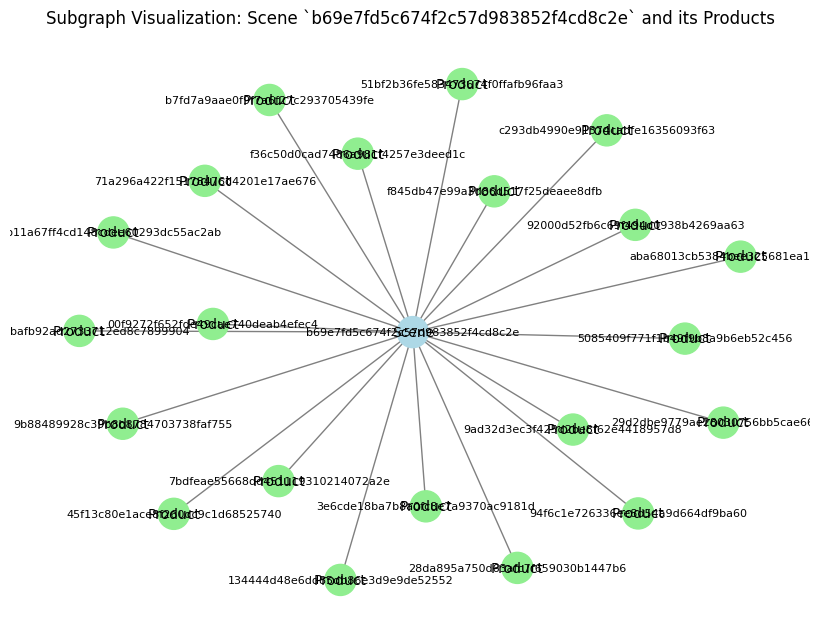

In [ ]:
# Visualize a subgraph

import matplotlib.pyplot as plt

# Select a random scene to visualize
sample_scene = list(fashion_data['scene'].unique())[5]  # Pick the first scene in the dataset

# Extract the products connected to this scene
connected_products = list(G.neighbors(sample_scene))

# Create a subgraph containing the scene and its products
subgraph_nodes = [sample_scene] + connected_products
subgraph = G.subgraph(subgraph_nodes)

# Plot the subgraph
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(subgraph, seed=42)  # Compute layout
node_colors = ['lightblue' if G.nodes[n]['type'] == 'scene' else 'lightgreen' for n in subgraph.nodes]

nx.draw(subgraph, pos, with_labels=True, node_size=500, node_color=node_colors, edge_color="gray", font_size=8)

# Label nodes with type
labels = {n: "Scene" if G.nodes[n]['type'] == 'scene' else "Product" for n in subgraph.nodes}
nx.draw_networkx_labels(subgraph, pos, labels=labels, font_size=10, font_color="black")

plt.title(f"Subgraph Visualization: Scene `{sample_scene}` and its Products")
plt.show()


### Object Detection with YOLO (skipped due to time constraints)
- this will run object detection with YOLO and save the detected objects as part of the node attributes.
- this will crop the product out of the scene using the bounding box values provided.


* This step was running too long with 70000* images to process, and it doesn't look like it was accurately detecting images.  I will hold off on adding these features for now due to time constraints, and will mention as a potential future work.

In [ ]:
# Select a sample scene
sample_scene = list(fashion_data['scene'].unique())[5]

# Find all product nodes connected to this scene
connected_products = [n for n in G.neighbors(sample_scene) if G.nodes[n]['type'] == 'product']

print(f"✅ Products linked to scene {sample_scene}:")
print(connected_products[:6])


✅ Products linked to scene b69e7fd5c674f2c57d983852f4cd8c2e:
['00f9272f652fde49cae740deab4efec4', '29d2dbe9779ae28030756bb5cae66042', '9ad32d3ec3f425d2be8f62e4418957d8', 'b11a67ff4cd148cdee60293dc55ac2ab', 'a84b5ebafb92ad2733712ed8c7899904', 'b7fd7a9aae0f9f7a6f27c293705439fe']


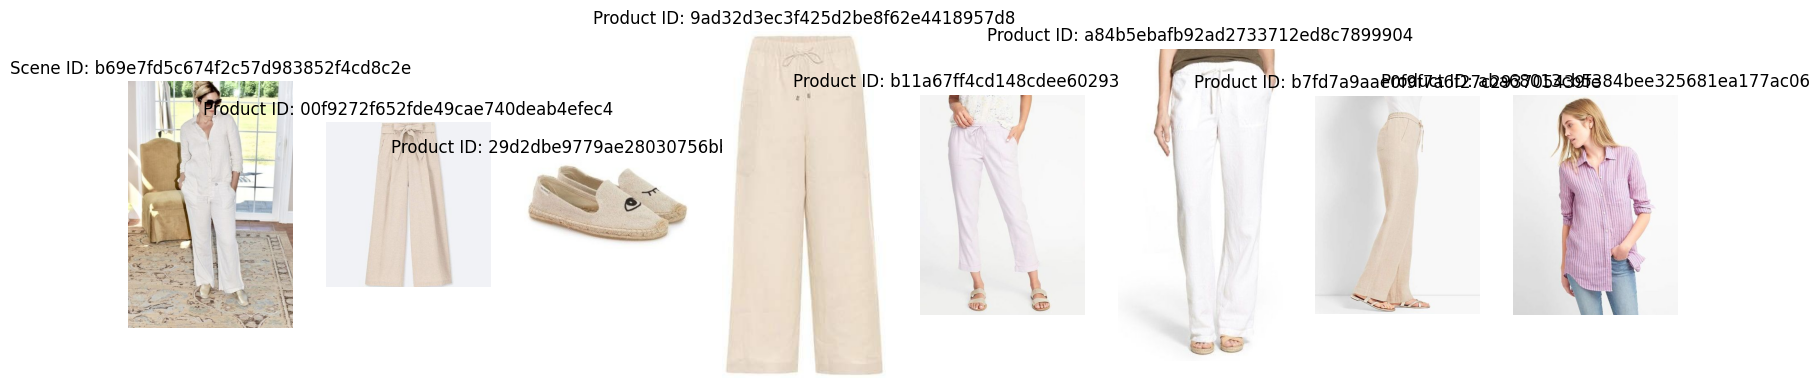

In [ ]:
# Function to verify cropped images
def verify_cropped_images(scene_id, product_list):
    fig, axes = plt.subplots(1, len(product_list)+1, figsize=(20, 5))

    scene_url = f"http://i.pinimg.com/400x/{scene_id[:2]}/{scene_id[2:4]}/{scene_id[4:6]}/{scene_id}.jpg"
    scene_image = download_image(scene_url)
    i = 0
    axes[i].imshow(scene_image)
    axes[i].set_title(f"Scene ID: {scene_id}")
    axes[i].axis("off")

    for i, product_id in enumerate(product_list):
        # row = fashion_data.iloc[idx]
        # product_id = row["product"]
        # scene_id = row["scene"]
        # bbox = row["bbox"]

        # Construct scene image URL
        product_url = f"http://i.pinimg.com/400x/{product_id[:2]}/{product_id[2:4]}/{product_id[4:6]}/{product_id}.jpg"

        # Download the scene image
        scene_image = download_image(product_url)

        if scene_image:
            # Crop the product from the scene
            # cropped_product = crop_product_from_scene(scene_image, bbox)

            # Display the cropped product
            axes[i+1].imshow(scene_image)
            axes[i+1].set_title(f"Product ID: {product_id}")
            axes[i+1].axis("off")

    plt.show()

# Run verification
verify_cropped_images("b69e7fd5c674f2c57d983852f4cd8c2e", connected_products[:7])

## >>> END OF YOLO Processing <<<

### Group `K` products by category



In [ ]:
# Group products by Category
from collections import defaultdict
import random

# Convert category vectors to labels (hashable)
category_to_products = defaultdict(list)

for node in G.nodes():
    if G.nodes[node]['type'] == 'product':
        category_vector = tuple(G.nodes[node].get('category_vector', []))  # Convert array to tuple (hashable)
        category_to_products[category_vector].append(node)

# Reduce category-based neighbors further
K = 5
edges = []

for products in category_to_products.values():
    if len(products) > 1:
        random.shuffle(products)
        for i in range(len(products)):
            for j in range(i + 1, min(i + 1 + K, len(products))):
                edges.append((products[i], products[j]))

# Increase weight of scene-based edges
for edge in G.edges():
    if G[edge[0]][edge[1]]['relation'] == 'appears_in':
        G[edge[0]][edge[1]]['weight'] = 2  # Give more importance to scene edges

#### Check degree distribution (number of edges per node)

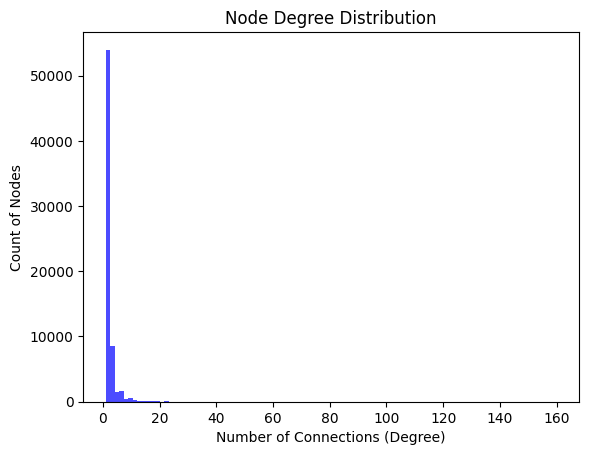

In [ ]:
import matplotlib.pyplot as plt

degrees = [deg for _, deg in G.degree()]
plt.hist(degrees, bins=100, color='blue', alpha=0.7)
plt.xlabel("Number of Connections (Degree)")
plt.ylabel("Count of Nodes")
plt.title("Node Degree Distribution")
plt.show()


### Convert graph to PyTorch Geometric Format

PyTorch Geometric requires the graph to be in tensor format, so we need to:



1.   Extract edge relationships (edge_index).
2.   Convert node features (category vectors) into tensors.








In [ ]:
# Convert updated graph to tensor format
node_to_index = {node: i for i, node in enumerate(G.nodes())}
edge_index = torch.tensor([(node_to_index[src], node_to_index[dst]) for src, dst in G.edges()], dtype=torch.long).t().contiguous()

# Extract node features
node_features = np.array([
    G.nodes[node]['category_vector'] if G.nodes[node]['type'] == 'product' else np.zeros(len(mlb.classes_))
    for node in G.nodes()
], dtype=np.float32)

# Convert to PyTorch tensor
x = torch.from_numpy(node_features)

# Create PyG Data object
pyg_data = Data(x=x, edge_index=edge_index)

# Print Summary

print(f"Number of Nodes: {pyg_data.num_nodes}")
print(f"Number of Edges: {pyg_data.num_edges}")
print(f"Feature Matrix Shape: {pyg_data.x.shape}")


Number of Nodes: 67549
Number of Edges: 72198
Feature Matrix Shape: torch.Size([67549, 14])


In [ ]:
from sklearn.preprocessing import StandardScaler
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

scaler = StandardScaler()
pyg_data.x = torch.tensor(scaler.fit_transform(pyg_data.x.cpu().numpy()), dtype=torch.float).to(device)

# Verify after normalization
print("Feature Matrix Mean After Normalization:", pyg_data.x.mean().item())
print("Feature Matrix Std Dev After Normalization:", pyg_data.x.std().item())


Feature Matrix Mean After Normalization: -2.323462089393047e-09
Feature Matrix Std Dev After Normalization: 1.0000004768371582


### Modeling:Uses Graph Attention Networks (GAT)

Final model:
- 2-layer GAT with residual connections to prevent over-smoothing.
- Dropout (0.3) to reduce overfitting.
- Contrastive Loss to encourage embedding separation.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv

# Model V1
class GATModel1(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=4, dropout=0.3):
        super(GATModel1, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads, concat=True, dropout=dropout)
        self.bn1 = nn.BatchNorm1d(hidden_channels * heads)
        self.conv2 = GATConv(hidden_channels * heads, hidden_channels, heads=1, concat=False, dropout=dropout)
        self.bn2 = nn.BatchNorm1d(hidden_channels)
        self.conv3 = GATConv(hidden_channels, hidden_channels, heads=1, concat=False, dropout=dropout)  # Extra Layer
        self.bn3 = nn.BatchNorm1d(hidden_channels)
        self.conv4 = GATConv(hidden_channels, out_channels, heads=1, concat=False, dropout=dropout)  # Extra Layer
        self.bn4 = nn.BatchNorm1d(out_channels)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.bn1(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index).relu()
        x = self.bn2(x)
        x = self.dropout(x)
        x = self.conv3(x, edge_index).relu()
        x = self.bn3(x)
        x = self.dropout(x)
        x = self.conv4(x, edge_index)
        x = self.bn4(x)
        return x

# Model V2
# import torch.nn as nn
# from torch_geometric.nn import GATConv

# class GATModel(nn.Module):
#     def __init__(self, in_channels, hidden_channels, out_channels, heads=4, dropout=0.3):
#         super(GATModel, self).__init__()
#         self.conv1 = GATConv(in_channels, hidden_channels, heads=heads, concat=True, dropout=dropout)
#         self.conv2 = GATConv(hidden_channels * heads, out_channels, heads=1, concat=False, dropout=dropout)  # Reduced layers
#         self.dropout = nn.Dropout(dropout)

#     def forward(self, x, edge_index):
#         x = self.conv1(x, edge_index).relu()
#         x = self.dropout(x)
#         x = self.conv2(x, edge_index)
#         return x

# Model V3


class GATModel3(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=4, dropout=0.3):
        super(GATModel3, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads, concat=True, dropout=dropout)
        self.conv2 = GATConv(hidden_channels * heads, out_channels, heads=1, concat=False, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.skip = nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        identity = self.skip(x)
        x = self.conv1(x, edge_index).relu()
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return x + identity


In [ ]:
import torch.nn.functional as F

def contrastive_loss1(embeddings, edge_index):
    src, dst = edge_index
    similarity = F.cosine_similarity(embeddings[src], embeddings[dst])

    negative_samples = torch.randint(0, embeddings.size(0), (src.shape[0],), device=embeddings.device)
    negative_similarity = F.cosine_similarity(embeddings[src], embeddings[negative_samples])

    # Use BCEWithLogitsLoss for better gradient updates
    logits = torch.cat([similarity, negative_similarity])
    targets = torch.cat([torch.ones_like(similarity), torch.zeros_like(negative_similarity)])

    loss = F.binary_cross_entropy_with_logits(logits, targets)
    return loss

# V2
# def contrastive_loss(embeddings, edge_index):
#     src, dst = edge_index
#     similarity = F.cosine_similarity(embeddings[src], embeddings[dst])

#     # Sample random negative products (not directly connected in the graph)
#     negative_samples = torch.randint(0, embeddings.size(0), (src.shape[0],), device=embeddings.device)
#     negative_similarity = F.cosine_similarity(embeddings[src], embeddings[negative_samples])

#     # Apply margin-based loss to separate dissimilar products
#     margin = 0.5
#     loss = F.relu(similarity - negative_similarity + margin).mean()

#     return loss

# V3
def contrastive_loss3(embeddings, edge_index):
    src, dst = edge_index
    similarity = F.cosine_similarity(embeddings[src], embeddings[dst])

    # Sample truly negative products (products that are NOT in the same category)
    negative_samples = torch.randint(0, embeddings.size(0), (src.shape[0],), device=embeddings.device)
    negative_similarity = F.cosine_similarity(embeddings[src], embeddings[negative_samples])

    # Apply margin-based loss to push dissimilar products apart
    margin = 0.5
    loss = F.relu(similarity - negative_similarity + margin).mean()

    return loss



In [ ]:

import torch.optim as optim

def train(model, data, epochs=50, lr=0.001, loss_func=contrastive_loss3):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_history = {}

    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(data.x.to(device), data.edge_index.to(device))
        # loss = cross_entropy_loss(out, data.edge_index.to(device))
        loss = loss_func(out, data.edge_index.to(device))

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient Clipping
        optimizer.step()
        loss_history[epoch] = round(loss.item(),4)

        if epoch == 0 or epoch == epochs - 1:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")
        # elif (epoch + 1) % 10 == 0
        #   print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

    return loss_history

In [ ]:
# # Initialize the new model
hidden_channels = 64
out_channels = 32
model1 = GATModel1(in_channels=pyg_data.x.shape[1], hidden_channels=hidden_channels, out_channels=out_channels).to(device)

# print(model)
loss_hist1 = train(model1, pyg_data, epochs=200, lr=0.0005, loss_func=contrastive_loss1)

model3 = GATModel3(in_channels=pyg_data.x.shape[1], hidden_channels=hidden_channels, out_channels=out_channels).to(device)

# print(model)
loss_hist3 = train(model1, pyg_data, epochs=500, lr=0.0005, loss_func=contrastive_loss3)


Epoch 1/200, Loss: 0.6561
Epoch 200/200, Loss: 0.6074
Epoch 1/500, Loss: 0.9679
Epoch 500/500, Loss: 0.5308


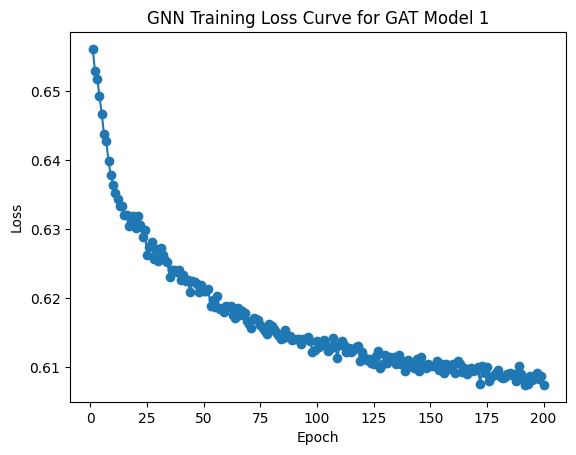

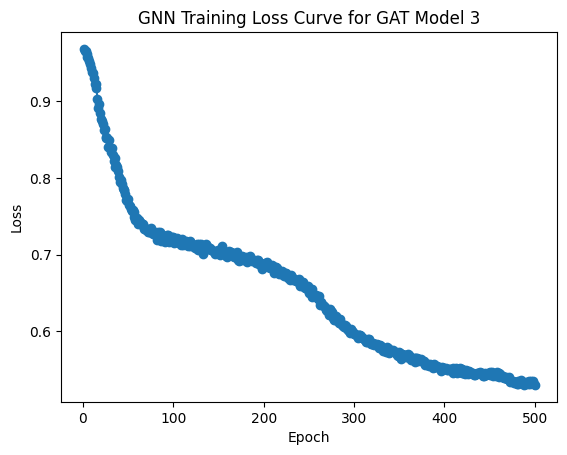

In [ ]:
# Plot loss history

import matplotlib.pyplot as plt

# Plot loss for model 1
plt.plot(range(1, len(loss_hist1) + 1), loss_hist1.values(), marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("GNN Training Loss Curve for GAT Model 1")
plt.show()

# Plot loss for model 1
plt.plot(range(1, len(loss_hist3) + 1), loss_hist3.values(), marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("GNN Training Loss Curve for GAT Model 3")
plt.show()

In [ ]:
base_dir

'drive/MyDrive/Colab Notebooks/UCB Deep Learning/week6'

In [ ]:
# Save the best model
# Define the file path to save the model
model = model3
num_epochs = 500
model_path = f"{base_dir}/gat_model.pth"

if 'optimizer' not in globals():
    import torch.optim as optim
    optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=5e-4)

# Save the trained model
torch.save({
    'model_state_dict': model.state_dict(),  # Model weights
    'optimizer_state_dict': optimizer.state_dict(),  # Optimizer state (optional)
    'epochs_trained': num_epochs  # Save the number of epochs trained
}, model_path)

print(f"Model saved successfully at {model_path}")



Model saved successfully at drive/MyDrive/Colab Notebooks/UCB Deep Learning/week6/gat_model.pth


In [ ]:
import torch

# Ensure model is in evaluation mode
model.eval()

# Compute embeddings without gradient tracking
with torch.no_grad():
    embeddings = model(pyg_data.x.to(device), pyg_data.edge_index.to(device))

# Convert embeddings into a dictionary for easy lookup
node_to_embedding = {i: embeddings[i].cpu().numpy() for i in range(len(embeddings))}

# Print sample embeddings
print(f"✅ Stored {len(node_to_embedding)} node embeddings.")


✅ Stored 67549 node embeddings.





## Visualize Data: Product Embeddings Clusters

- Distinct Clusters Are Formed:

    The products are separated into 5 clusters (Cluster 0 to Cluster 4), each represented by a different color.
    This means that the GNN learned some differentiation between product embeddings, but we need to assess how meaningful these clusters are.

- Overlapping Regions & Dense Clusters

    The blue and dark red clusters are densely packed and overlapping, which suggests that many product embeddings are still very similar.
    This aligns with our previous issue where similarity scores were too high (~0.999), meaning embeddings are not spreading out enough.
    Ideally, clusters should be more distinctly separated if they represent different fashion categories.

- Outlier Groups (Top Right & Top Center)

    There are small groups of products (grey & light red clusters) that are more isolated from the rest.
    This suggests that these embeddings are less connected to the other clusters and may correspond to niche fashion categories or unique styles.

- Some Products Spread Out More Than Others.  Certain points (bottom right and far left) are more isolated from their main cluster.
    This could mean these products don’t fit neatly into a specific cluster or that their embeddings didn’t learn strong relationships.

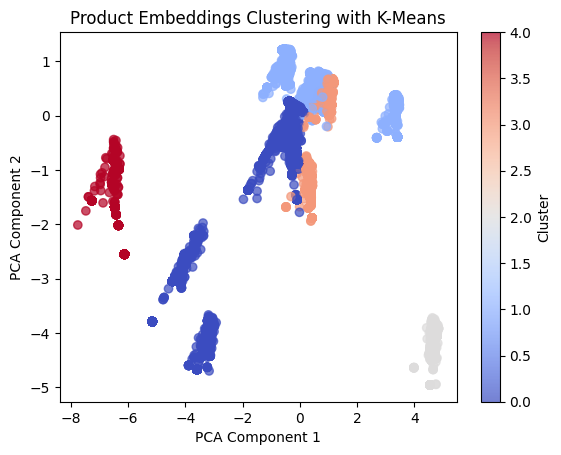

In [ ]:
from sklearn.cluster import KMeans

num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(embeddings)

plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=cluster_labels, cmap='coolwarm', alpha=0.7)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Product Embeddings Clustering with K-Means")
plt.colorbar(label="Cluster")
plt.show()


## Compute Similar Products Based on Embeddings

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
import numpy as np
import matplotlib.pyplot as plt

# Extract product nodes and their embeddings
product_nodes = [node for node in G.nodes() if G.nodes[node]['type'] == 'product']
product_embeddings = np.array([node_to_embedding[list(G.nodes()).index(p)] for p in product_nodes])
normalized_embeddings = normalize(product_embeddings)

# Compute cosine similarity matrix
similarity_matrix = cosine_similarity(normalized_embeddings)




In [ ]:
import numpy as np

total_similarity = 0
count = 0

for cat, products in category_to_products.items():
    product_indices = [product_nodes.index(p) for p in products]  # Get product indices

    if len(product_indices) > 1:  # Skip categories with only one product
        category_similarities = similarity_matrix[np.ix_(product_indices, product_indices)]

        # Sum all similarities EXCLUDING diagonal (self-similarity)
        total_similarity += np.sum(category_similarities) - np.sum(np.diag(category_similarities))

        count += len(product_indices) * (len(product_indices) - 1) / 2  # Unique pairs count

# Compute final average similarity
average_similarity = total_similarity / count if count > 0 else 0
print(f"Final Average Similarity Between Products in the Same Category: {average_similarity:.4f}")


✅ Final Average Similarity Between Products in the Same Category: 1.9263


In [ ]:
# Validate and print out similarity scores
sample_category = list(category_to_products.keys())[0]  # Choose the first category
sample_products = category_to_products[sample_category][:10]  # Take first 10 products

print(f"🔹 Category: {sample_category}")
print(f"🔹 Sample Products: {sample_products}")

for i, p1 in enumerate(sample_products):
    for j, p2 in enumerate(sample_products):
        if i < j:  # Avoid duplicate pairs
            idx1 = product_nodes.index(p1)
            idx2 = product_nodes.index(p2)
            sim_score = similarity_matrix[idx1, idx2]
            print(f"   - Similarity({p1}, {p2}) = {sim_score:.4f}")


🔹 Category: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0)
🔹 Sample Products: ['343b0dae9fb781ebfff067aa2c12f4d0', '002d3825468c128b789fbcda9926cb42', '3443852272109a7256d820a133cfe2b9', '178e764b87c74243a8954532eabdf547', 'b2946c57490604b4ef5fde5d969f2fcc', 'd1ad058bea05f046ce08f5de5fad0ac5', 'b175f106549618d9d518b13782fefdb9', '5a9574f6b1bafa89b73546a8dedf7a5b', 'b62d4faad4185be41ae56881d5483423', '78f4fa19454c5908d1b9685d70eecb83']
   - Similarity(343b0dae9fb781ebfff067aa2c12f4d0, 002d3825468c128b789fbcda9926cb42) = 1.0000
   - Similarity(343b0dae9fb781ebfff067aa2c12f4d0, 3443852272109a7256d820a133cfe2b9) = 0.9946
   - Similarity(343b0dae9fb781ebfff067aa2c12f4d0, 178e764b87c74243a8954532eabdf547) = 0.9996
   - Similarity(343b0dae9fb781ebfff067aa2c12f4d0, b2946c57490604b4ef5fde5d969f2fcc) = 0.9717
   - Similarity(343b0dae9fb781ebfff067aa2c12f4d0, d1ad058bea05f046ce08f5de5fad0ac5) = 1.0000
   - Similarity(343b0dae9fb781ebfff067aa2c12f4d0, b175f106549618d9d518b13782fefdb9) = 0.9996
   - Si

In [ ]:
import requests
from PIL import Image
from io import BytesIO

# Function to download and return an image from a URL
def download_image(image_url):
    try:
        response = requests.get(image_url)
        response.raise_for_status()  # Ensure we got a valid response
        return Image.open(BytesIO(response.content))  # Convert to PIL image
    except Exception as e:
        print(f"Error downloading {image_url}: {e}")
        return None  # Return None if the image fails to download



🔹 Product ID: d27922539efb4fa4f07b90841cdc4ccd
   - Top 5 Recommended Products: ['c92f58af226173ff62a8a6ad9a684e58', 'eed417bcd6e645dd51a64a50b4e48fb9', 'd0117fd7107ef556b2cae441f95cb710', 'c034af9145bdc4c1f6e91581c18df378', 'ce2e57c5b33590257480fa013ce97a9f']


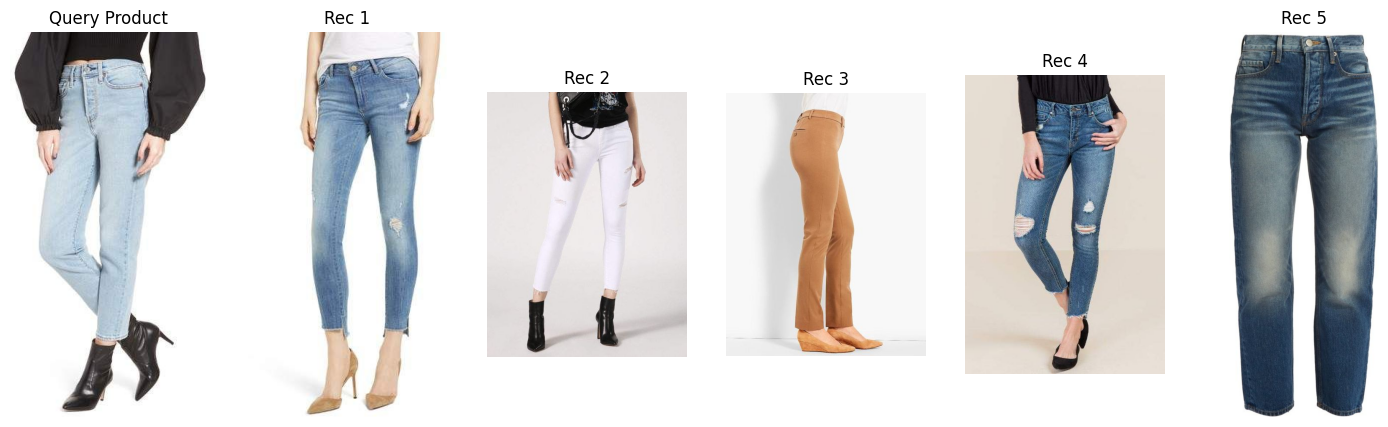

In [ ]:
def display_recommendations(sample_product, top_products):
    fig, axes = plt.subplots(1, 6, figsize=(18, 5))

    # Get image URL of the sample product
    sample_image_url = G.nodes[sample_product].get('image_url', None)
    sample_image = download_image(sample_image_url) if sample_image_url else None

    # Display sample product
    if sample_image:
        axes[0].imshow(sample_image)
        axes[0].set_title("Query Product")
        axes[0].axis("off")
    else:
        axes[0].set_title("No Image Found")
        axes[0].axis("off")

    # Display recommended products
    for i, product in enumerate(top_products):
        image_url = G.nodes[product].get('image_url', None)
        product_image = download_image(image_url) if image_url else None

        if product_image:
            axes[i + 1].imshow(product_image)
            axes[i + 1].set_title(f"Rec {i+1}")
            axes[i + 1].axis("off")
        else:
            axes[i + 1].set_title("No Image Found")
            axes[i + 1].axis("off")

    plt.show()

# Select a sample product
# sample_product = product_nodes[723]  # Choose a product for testing
sample_product = product_nodes[275]
sample_index = list(G.nodes()).index(sample_product)

# Get top 5 similar products (excluding itself)
top_indices = np.argsort(-similarity_matrix[sample_index])[1:6]  # Exclude itself
top_products = [product_nodes[i] for i in top_indices]

print(f"\n🔹 Product ID: {sample_product}")
print(f"   - Top 5 Recommended Products: {top_products}")
# Run visualization
display_recommendations(sample_product, top_products)


In [ ]:
# fashion_cat_dict["d8cc31e252cad7eeece3233fa574f9df"]
fashion_cat_dict["d27922539efb4fa4f07b90841cdc4ccd"]

'Apparel & Accessories|Clothing|Pants'

In [ ]:
# End of Notebook